This is an example run through to show how the match_audio_to_video workflow goes


Author : Thejasvi Beleyur, August 2019,
         Acoustic and Functional Ecology Group, Max Planck Institute for Ornithology, Seewiesen

In [1]:
import sys 
sys.path.append('../bin/') # include the modules in the outer folder in the search path
import pandas as pd
import numpy as np 


In [2]:
import os 
os.listdir('./')

['common_fps_video_sync555.csv',
 'Run through tutorial - matching_audio_to_video.ipynb',
 'audio',
 '.ipynb_checkpoints',
 'matching_sync_1.WAV',
 'matching_sync_0.WAV',
 'videosync_DVRecorder_03_20190704_16.49.45-16.56.42[R][@da37][0].avi_.csv',
 'get_videodata.py',
 'common_fps_video_sync202.csv',
 'eg_annotations.csv']

In [3]:
%matplotlib notebook

### Getting your borders right:
For reliable and quick light intensity tracking and timestamp reading it is best to provide a narrow region around the focal area. In my experience I've seen that the timestamp reading can get a bit wonky if the whole image is provided!

<IPython.core.display.Javascript object>


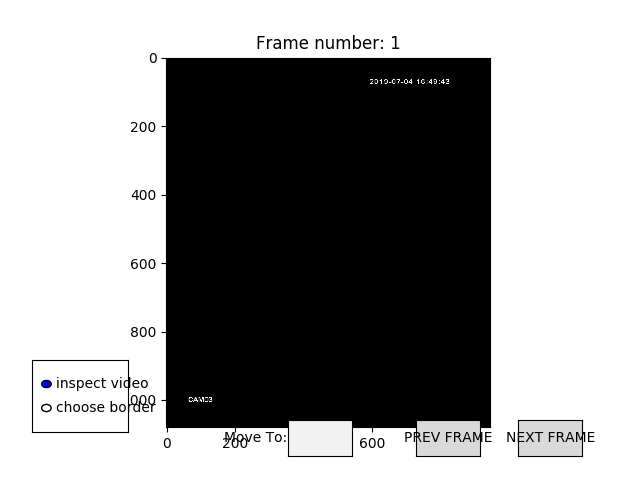

<IPython.core.display.Javascript object>


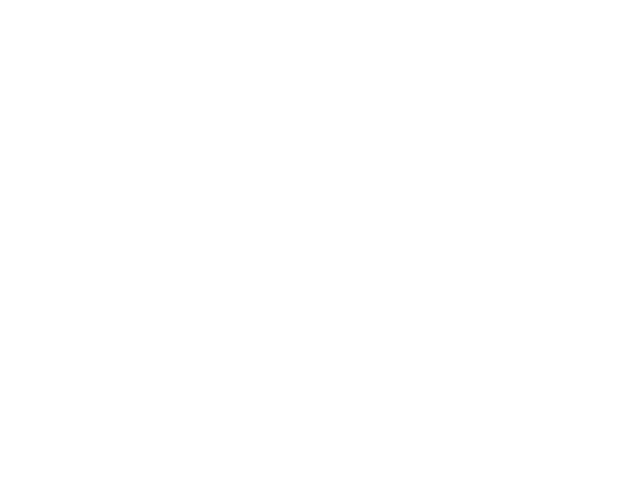

In [5]:
# Get the led and timestamp borders 
%run ../bin/browse_through_video.py -v '/media/tbeleyur/PEN_DRIVe/AV_synchronisation_experiment_4July2019/video/DVRecorder_03_20190704_16.49.45-16.56.42[R][@da37][0].avi'

So - for the example video the led_border entry should be (418.09, 792.16, 492.46, 246.62) *your points may be different than mine!!* - don't bother with too many decimal places! - repeat this once more to get the timestamp_border - and do this for every video file you have! 
The points are chosen by left click. If you want to delete an accidental click then use the right click. 
If you think the 4 points you chose still aren't right - no worries you can press the choose border button once more and redo the whole process. 

You could redo the border selection any time by keeping the frame-by-frame display open!

The border output you need to put into the annotations file is always printed out. 


### Running the video file level data production : tracking the light intensity and timestamps frame-by-frame
After entering your annotations, now run the  routine that will measure the light intensity in each frame and read the timestamp. 

In [ ]:
from generate_data_from_video import generate_videodata_from_videofiles

annotations_df = pd.read_csv('5am-6am.csv')
# Since it's a small video with only 1370 frames - we'll run the whole thing! This could take a couple of minutes


The step above should have given a .csv file with the following template : *videosync_file path here_.csv*. You will notice the 'timestamp_verified' columns is blank. This is because the effectiveness of the OCR can vary a lot. Copy the 'timestamp' column into timestamp_verified and correct the entries wherever they look weird. It may be useful especially to check along transition points ie. where the second changes or the date changes - sometimes the change in the numbers are not detected. 

This is also the point at which you can run *browse_through_video* and run through the videos keeping the interface on inspect video mode. For instance you might see a misread at frame 186 (indexing starts from 1 in the package!), and some others at 16:26:25. 


In [ ]:
df = pd.read_csv('videosync_DVRecorder_03_20190704_16.49.45-16.56.42[R][@da37][0].avi_.csv')

In [ ]:
timestamps, counts = np.unique(df['timestamp'], return_counts=True)


In [ ]:
%run ../browse_through_video.py -v './vlc-record_03_20190704_16-51-30to16-52[R][@da37][0].avi'

In [ ]:
df = pd.read_csv('videosync_DVRecorder_03_20190704_16.49.45-16.56.42[R][@da37][0].avi_.csv')

In [ ]:
plt.figure()
plt.plot(df['led_intensity'])

In [ ]:
import numpy as np 

In [ ]:
timestamps, numtimes = np.unique(df['timestamp_verified'], return_counts=True)

In [ ]:
timestamps, numtimes

### Resampling the led signal and checking for dropped frames :
The *videosync* file is raw data. Depending on your camera+DVR system there could be dropped frames or the framerate may vary over time. These issues need to be detected and corrected for at the level of each annotation. 

The output of this step is a series of *commonfps* files.

In [ ]:
from process_video_annotations import video_sync_over_annotation_block

annotations = pd.read_csv('eg_annotations.csv')
whole_video_data = pd.read_csv('videosync_DVRecorder_03_20190704_16.49.45-16.56.42[R][@da37][0].avi_.csv')

kwargs = {'timestamp_pattern': '%Y-%m-%d %H:%M:%S'}
kwargs['min_fps']= 20 # Hz
kwargs['min_durn'] = 20.0 # seconds 
kwargs['common_fps'] = 25 # Hz

success = annotations.apply(video_sync_over_annotation_block,1, video_sync_data=whole_video_data , 
                                 **kwargs)
print(success)


In [ ]:
### Finding the matching audio snippet !! 
import glob 
import soundfile as sf
from audio_for_videoannotation import match_video_sync_to_audio

#all_commonfps = glob.glob('common_fps_video_sync*') # get all the relevant common_fps_sync files
all_commonfps = glob.glob('./common_fps*')
audio_folder = 'audio/' # the current folder
fs = 500000
# generate the 
for somenumber, each_commonfps in enumerate(sorted(all_commonfps)):
    print(each_commonfps)
    video_sync = pd.read_csv(each_commonfps)
    best_audio, crosscoef = match_video_sync_to_audio(video_sync, audio_folder, audio_fileformat='*.wav',
                                           audio_sync_spikey=False)
                                                                 
    sf.write('./matching_sync_'+str(somenumber)+'.WAV', best_audio,fs)